In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import json

##1. Importing the DataBase:

In [ ]:
input_file = "/content/apk_nutriscore.csv"
data = pd.read_csv(input_file)
weights_w1 = {
    "energy": 4,
    "sugars": 3,
    "saturated_fat": 3,
    "salt": 3,
    "proteins": 2,
    "fiber": 2,
    "fruits_vegetables": 1,
}

thresholds = [0.5, 0.55, 0.6]
lambda_to_analyze = 0.5


##2. Exploring Data:

In [ ]:
data

,product_name,brand,categories,barcode,nutriscore,ecoscore,ecoscore_global,energy,sugars,proteins,saturated_fat,salt,fiber,fruits_vegetables,category
0,Céréales Chocapic,Nestlé,"Plant-based foods and beverages,Plant-based fo...",7613034626844,C,E,28.0,388.0,22.40,8.80,2.00,0.220,7.5,0.000000,breakfast cereals
1,Weetabix,Weetabix,"Plant-based foods and beverages, Plant-based f...",5010029000016,A,D,38.0,362.0,4.40,12.00,0.60,0.275,10.0,0.000000,breakfast cereals
2,Muesli Superfruits,Bjorg,"Plant-based foods and beverages,Plant-based fo...",3229820782560,A,A,87.0,357.0,14.00,11.00,0.80,0.010,9.4,20.979021,breakfast cereals
3,NESTLE CHOCAPIC Céréales 750g,Nestlé,"Plant-based foods and beverages,Plant-based fo...",7613034947611,C,D,30.0,388.0,22.40,8.80,2.00,0.220,7.5,0.000000,breakfast cereals
4,Corn Flakes,Kellogg's,"Plant-based foods and beverages,Plant-based fo...",3159470000120,D,E,29.0,378.0,8.00,7.00,0.20,1.100,3.0,0.000000,breakfast cereals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,Nouilles instantanées curry,"Tables du Monde,Marque Repère","Aliments et boissons à base de végétaux, Alime...",3564706501911,C,C,52.0,460.0,3.30,11.00,11.00,4.600,1.7,9.700000,noodles
797,Nissin Lámen Galinha Caipira,"Nissin,Miojo","Plant-based foods and beverages,Plant-based fo...",7891079000229,C,B,63.0,448.0,1.65,9.76,8.12,4.140,2.0,0.746053,noodles
798,Cellentani,"Buitoni, Sansepolcro, Delverde","Plant-based foods and beverages, Plant-based f...",8000270013115,A,B,65.0,357.0,3.10,12.50,0.30,0.020,3.2,0.000000,noodles
799,Oyakata Kurczak Teriyaki,Ajinomoto,"Plant-based foods and beverages, Plant-based f...",5901384502768,D,C,55.0,242.0,4.10,4.90,4.70,1.770,0.0,4.705587,noodles


## 2. Setting the limitting profiles :

We decides for comparaison to use the limitting profiles that gave the best results on our data set, which were obtained by using the k-means approch:

In [ ]:
def calculate_limiting_profiles(df, num_clusters=5):
    nutritional_features = [
        "energy",
        "sugars",
        "saturated_fat",
        "salt",
        "proteins",
        "fiber",
        "fruits_vegetables"
    ]
    data = df[nutritional_features].dropna()
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data)

    centroids = kmeans.cluster_centers_

    limiting_profiles = pd.DataFrame(
        centroids.T,  # Transpose to have rows as criteria
        index=nutritional_features,
        columns=["A", "B", "C", "D", "E"][:num_clusters]  # Nutri-Score categories as columns
    )

    return limiting_profiles

In [ ]:
limiting_profiles = calculate_limiting_profiles(data)
limiting_profiles

,A,B,C,D,E
energy,461.536971,200.447995,362.982957,114.345000,405.658072
sugars,19.105068,1.404866,13.951005,1.201289,19.554819
saturated_fat,5.091795,2.117866,1.380196,0.705762,2.885664
salt,0.476883,1.507791,0.344911,1.067706,0.323040
proteins,10.082958,15.489449,9.933327,16.357111,8.764138
fiber,7.271620,0.926480,8.170158,0.696722,7.450405
fruits_vegetables,12.981054,9.544250,9.979643,5.056630,12.334759


##2. MDCA: Optimistic approch

In [ ]:
def optimistic_majority_sorting(data, weights, limiting_profiles, lambda_values):
    # Normalize data based on criteria type
    criteria_to_minimize = ["energy", "sugars", "saturated_fat", "salt"]
    for col in criteria_to_minimize:
        data[col] = 10 - data[col]

    criteria_to_maximize = ["proteins", "fiber", "fruits_vegetables"]
    for col in criteria_to_maximize:
        data[col] = 2 * data[col]

    # Prepare profiles in a structured format
    relevant_columns = ["energy", "sugars", "saturated_fat", "salt", "proteins", "fiber", "fruits_vegetables"]
    profiles = {k: np.array([v[c] for c in relevant_columns]) for k, v in limiting_profiles.items()}

    # Compute concordance indices
    def concordance(a, b, weights, relevant_columns):
        # Changed here to use the name of the criteria instead of the index
        return np.sum([weights[col] for col, a_val, b_val in zip(relevant_columns, a, b) if a_val >= b_val])


    # Assign categories using the optimistic approach
    def assign_category(food, profiles, lambda_threshold, weights, relevant_columns):
        for category, profile in profiles.items():
            if concordance(profile, food, weights, relevant_columns) >= lambda_threshold:
                return category
        return "E"  # Default to the worst category if no match is found
    results = []
    relevant_columns = ["energy", "sugars", "saturated_fat", "salt", "proteins", "fiber", "fruits_vegetables"]
    profiles = {k: np.array([v[c] for c in relevant_columns]) for k, v in limiting_profiles.items()}
    for lambda_threshold in thresholds:
        for _, row in data.iterrows():
            food_name = row["product_name"]  # Assuming "Food Name" column exists
            nutri_score = row["nutriscore"]  # Keep the Nutri-Score column
            food = row[relevant_columns].values
            # Changed here to pass also the relevant columns
            category = assign_category(food, profiles, lambda_threshold, weights_w1, relevant_columns)
            results.append({"Product Name": food_name, "Nutri-Score": nutri_score, "Category": category, "Lambda": lambda_threshold})
    # Convert results to DataFram
    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
results_optimistic = optimistic_majority_sorting(data, weights_w1, limiting_profiles, thresholds)

In [ ]:
results_optimistic

,Product Name,Nutri-Score,Category,Lambda
0,Céréales Chocapic,C,A,0.5
1,Weetabix,A,A,0.5
2,Muesli Superfruits,A,A,0.5
3,NESTLE CHOCAPIC Céréales 750g,C,A,0.5
4,Corn Flakes,D,A,0.5
...,...,...,...,...
2398,Nouilles instantanées curry,C,A,0.6
2399,Nissin Lámen Galinha Caipira,C,A,0.6
2400,Cellentani,A,A,0.6
2401,Oyakata Kurczak Teriyaki,D,A,0.6


In [ ]:
df_optimistic = pd.DataFrame(results_optimistic)
df_optimistic

,Product Name,Nutri-Score,Category,Lambda
0,Céréales Chocapic,C,A,0.5
1,Weetabix,A,A,0.5
2,Muesli Superfruits,A,A,0.5
3,NESTLE CHOCAPIC Céréales 750g,C,A,0.5
4,Corn Flakes,D,A,0.5
...,...,...,...,...
2398,Nouilles instantanées curry,C,A,0.6
2399,Nissin Lámen Galinha Caipira,C,A,0.6
2400,Cellentani,A,A,0.6
2401,Oyakata Kurczak Teriyaki,D,A,0.6


### Confusion matrix

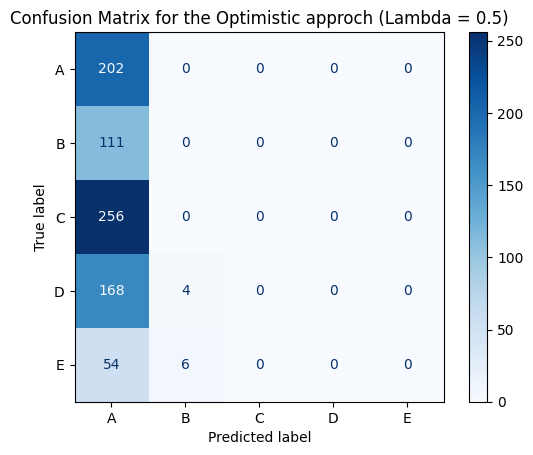

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Select Lambda value to analyze
lambda_to_analyze = 0.5
subset = results_optimistic[results_optimistic["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri-Score"]
y_pred = subset["Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for the Optimistic approch (Lambda = {lambda_to_analyze})")
plt.show()

### Evaluation metrics:

In [ ]:
# Calculate and print accuracy
accuracy_3 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_3:.2f}")

# Calculate and print precision
precision_3 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_3:.2f}")

# Calculate and print recall
recall_3 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_3:.2f}")

# Calculate and print F1 score
f3 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f3:.2f}")

Accuracy: 0.25
Precision: 0.05
Recall: 0.20
F1 Score: 0.08


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


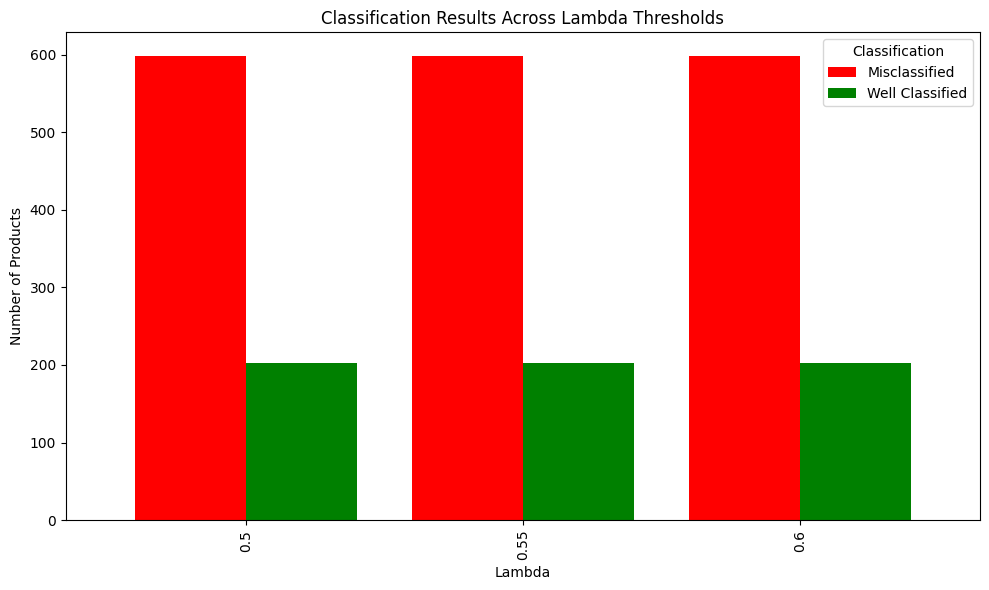

In [ ]:
df_optimistic['Well Classified'] = df_optimistic['Nutri-Score'] == df_optimistic['Category']
classification_counts = df_optimistic.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar',
    stacked=False,
    figsize=(10, 6),
    color=['red', 'green'],
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

### Discussion


##3. MCDA : Pessimistic approch

In [ ]:
def transform_criteria(row):

    transformed_row = row.copy()
    for criterion in row.index:
        if criterion in ["energy", "sugars", "saturated_fat", "salt"]:  # Minimized
            transformed_row[criterion] = 10 - row[criterion]
        elif criterion in ["proteins", "fiber", "fruits_vegetables"]:  # Maximized
            transformed_row[criterion] = 2 * row[criterion]
    return transformed_row

def compute_concordance(item, profile, weights):

    transformed_item = transform_criteria(item)
    concordance = 0
    total_weight = sum(weights.values())
    for criterion, value in profile.items():
        if criterion in ["proteins", "fiber", "fruits_vegetables"]:
            # Criteria to maximize
            if transformed_item[criterion] >= value:
                concordance += weights[criterion]
        else:
            # Criteria to minimize
            if transformed_item[criterion] <= value:
                concordance += weights[criterion]
    return concordance / total_weight

def pessimistic_majority_sorting(item, profiles, weights, lambda_threshold):
    for category, profile in sorted(profiles.items()):
        concordance = compute_concordance(item, profile, weights)
        if concordance >= lambda_threshold:
            return category

In [ ]:
results = []
for _, row in data.iterrows():
    for lambda_value in thresholds:
        pessimistic_category_3 = pessimistic_majority_sorting(row, limiting_profiles, weights_w1, lambda_value)

        results.append({
            "Product Name": row["product_name"],
            "Nutri score": row["nutriscore"].upper(),
            "Lambda": lambda_value,
            "Pessimistic Category": pessimistic_category_3
        })

df_pessemistic = pd.DataFrame(results)
df_pessemistic

,Product Name,Nutri score,Lambda,Pessimistic Category
0,Céréales Chocapic,C,0.50,A
1,Céréales Chocapic,C,0.55,A
2,Céréales Chocapic,C,0.60,A
3,Weetabix,A,0.50,A
4,Weetabix,A,0.55,A
...,...,...,...,...
2398,Oyakata Kurczak Teriyaki,D,0.55,None
2399,Oyakata Kurczak Teriyaki,D,0.60,None
2400,Kit bo bun,D,0.50,None
2401,Kit bo bun,D,0.55,None


### Confusion Matrix:

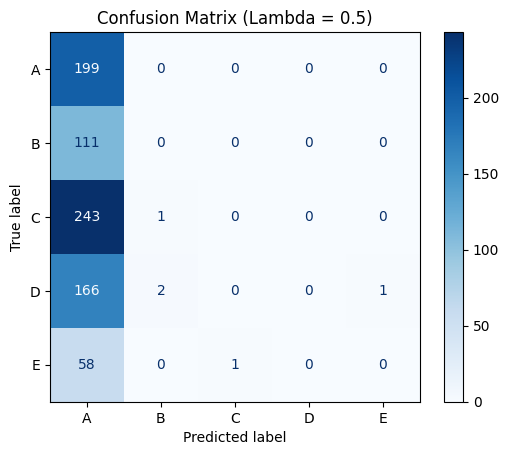

In [ ]:
subset = df_pessemistic[df_pessemistic["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri score"].dropna()
y_pred = subset["Pessimistic Category"].dropna()
valid_indices = y_true.notnull() & y_pred.notnull()
y_true = y_true[valid_indices]
y_pred = y_pred[valid_indices]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Lambda = {lambda_to_analyze})")
plt.show()

### Evaluation metrics:

In [ ]:
# Calculate and print accuracy
accuracy_3 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_3:.2f}")

# Calculate and print precision
precision_3 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_3:.2f}")

# Calculate and print recall
recall_3 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_3:.2f}")

# Calculate and print F1 score
f3 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f3:.2f}")

Accuracy: 0.25
Precision: 0.05
Recall: 0.20
F1 Score: 0.08


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


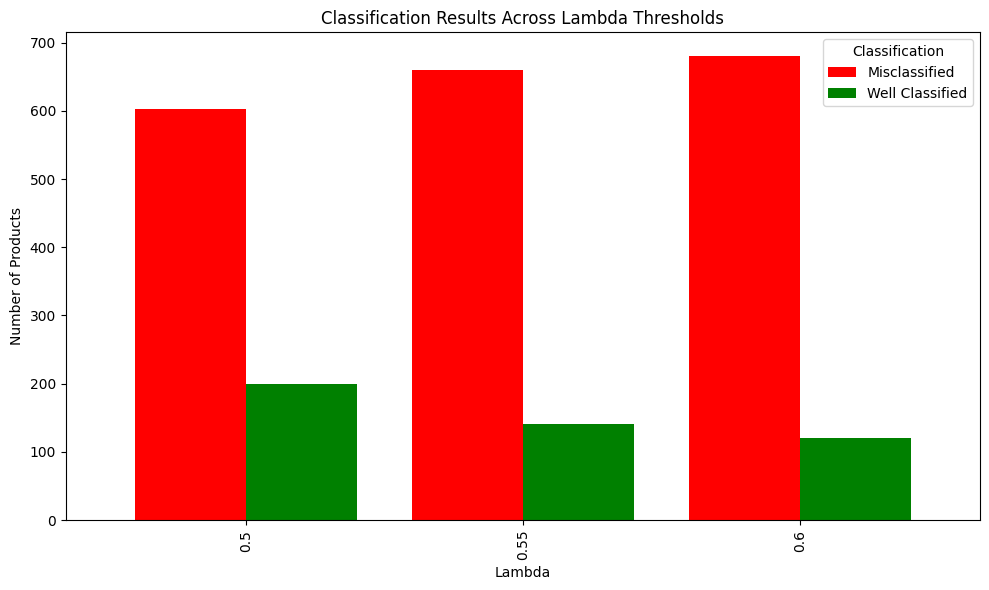

In [ ]:
df_pessemistic['Well Classified'] = df_pessemistic['Nutri score'] == df_pessemistic['Pessimistic Category']
classification_counts = df_pessemistic.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar',
    stacked=False,
    figsize=(10, 6),
    color=['red', 'green'],
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

### Discussion :

* The results obtained with this dataset were worse than the results that we got using our dataset.
* In our case using these limitting profiles we got an accuracy of 0.43 weras using this team dataset we got an accuracy of 0.25.
* Most rows were assigned to class A, wich is the same as in our dataset.